In [1]:
%matplotlib inline
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo import spa

In [3]:
from imem.analysis.context import band_average, context_vectors, stimulus_vectors
from imem.legacy.context import Context4
from imem.utils import inhibit_net

In [4]:
d = 64
beta = 0.6
n = 10

rng = np.random.RandomState(seed=1)
vocab = spa.Vocabulary(d, rng=rng)

stimuli = [x for i, x in zip(range(n), stimulus_vectors(vocab))]

In [5]:
def context_initialization(t):
    if t < 1.:
        return vocab.parse('INIT').v
    else:
        return np.zeros(d)
    
def update_context(t):
    if t < .5 or (t > 1. and .3 < (t % 1.) < .7):
        return 1.
    else:
        return 0.

with nengo.Network(seed=2) as model:
    input_node = nengo.Node(lambda t: stimuli[min(int(t), len(stimuli) - 1)])
    context_net = Context4(d, beta)
    nengo.Connection(input_node, context_net.input)
    
    nengo.Connection(nengo.Node(update_context), context_net.input_update_context)
    
    initialization_node = nengo.Node(context_initialization)
    nengo.Connection(initialization_node, context_net.current.diff.input)
    nengo.Connection(nengo.Node(lambda t: 4 if t < 0.5 else 0.), context_net.old.store)
    nengo.Connection(nengo.Node(lambda t: -1 if t < 0.4 else 0.), context_net.buf.store)
    
    p_in = nengo.Probe(input_node, synapse=0.01)
    p_out = nengo.Probe(context_net.output, synapse=0.01)
    p_buf = nengo.Probe(context_net.buf.mem.output, synapse=0.01)
    p_old = nengo.Probe(context_net.old.mem.output, synapse=0.01)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(n)

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


In [57]:
from imem.analysis.context import context_vectors

In [7]:
actual_ctx = np.mean([sim.data[p_out][(1000 * i + 500):(1000 * i + 800)] for i in range(n)], axis=1)
actual_ctx /= np.linalg.norm(actual_ctx, axis=1)[:, None]
ideal_ctx = np.asarray([context_vectors(vocab, beta, stimuli) for i in range(env.n)])

In [8]:
actual_ctx_similarities = band_average(np.dot(actual_ctx, actual_ctx.T))
ideal_ctx_similarities = band_average(np.dot(ideal_ctx, ideal_ctx.T))

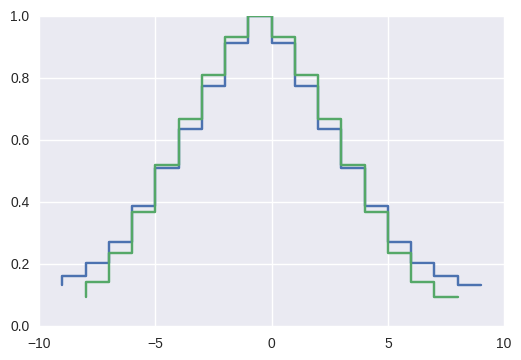

In [9]:
plt.step(np.arange(-n + 1, n), actual_ctx_similarities)
plt.step(np.arange(-n + 2, n - 1), ideal_ctx_similarities)

(0, 10.0)

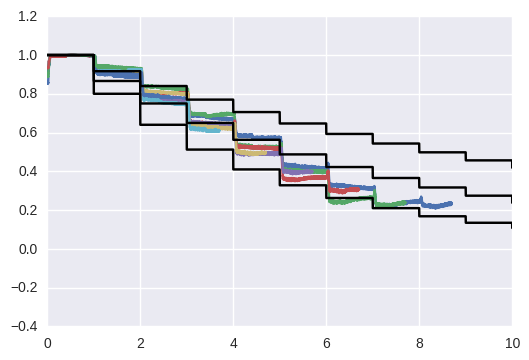

In [45]:
b = np.array(sim.data[p_out])
b /= np.linalg.norm(b, axis=1)[:, None]
for i in range(1, 10):
    a = np.mean(sim.data[p_out][1000 * i + 700:1000 * i + 1000], axis=0)
    a /= np.linalg.norm(a)
    y = np.dot(b, a)
    plt.plot(sim.trange() - i - .3, y)
plt.plot(sim.trange(), np.sqrt(1. - .6**2) ** np.floor(sim.trange()), 'k')
plt.plot(sim.trange(), np.sqrt(1. - .5**2) ** np.floor(sim.trange()), 'k')
plt.plot(sim.trange(), np.sqrt(1. - .4**2) ** np.floor(sim.trange()), 'k')
plt.xlim(left=0)

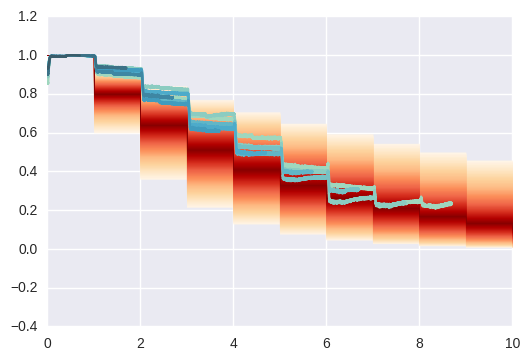

In [47]:
sns.set_palette(sns.color_palette("GnBu_d", 10)[::-1])
out_normed = sim.data[p_out] / np.linalg.norm(sim.data[p_out], axis=1)[:, None]
for i in range(1, 10):
    start = int((i + .7) / sim.dt)
    end = int((i + 1.) / sim.dt)
    target = np.mean(out_normed[start:end], axis=0)
    y = np.dot(out_normed, target)
    plt.plot(sim.trange() - i -.3, y)
#plt.plot(sim.trange(), np.sqrt(1. - beta**2) ** np.floor(sim.trange()))
t = sim.trange()
beta_diffs = np.linspace(0, 0.2)
for x, c in zip(reversed(beta_diffs), sns.color_palette('OrRd', len(beta_diffs))):
    plt.fill_between(t, np.sqrt(1. - (beta - x)**2)**np.floor(t), np.sqrt(1. - (beta + x)**2)**np.floor(t), color=c)
#plt.plot(sim.trange(), np.sqrt(1. - .6**2) ** np.floor(sim.trange()), 'k')
#plt.plot(sim.trange(), np.sqrt(1. - .5**2) ** np.floor(sim.trange()), 'k')
#plt.plot(sim.trange(), np.sqrt(1. - .4**2) ** np.floor(sim.trange()), 'k')
plt.xlim(left=0)
sns.despine()

In [51]:
sns.set('paper', 'ticks')

from matplotlib import gridspec
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, Normalize

t = sim.trange()

fig = plt.figure(figsize=(6.3, 6.3 / 2.))
subplots = gridspec.GridSpec(2, 2, width_ratios=(1., 2.))

ax1 = fig.add_subplot(subplots[0, 0])
ax1.plot(t, np.linalg.norm(sim.data[p_out], axis=1))
ax1.axhline(y=1., c='k', ls='--')
ax1.set_ylabel("Norm of context vector")
ax1.set_yticks([0, 1])

with sns.color_palette("husl", 10):
    ax2 = fig.add_subplot(subplots[1, 0], sharex=ax1)
    y = np.sum(sim.data[p_in] * sim.data[p_out], axis=1)
    for i in range(1, 10):
        sel = (t > i) & (t <= i + 1)
        plt.plot(t[sel], y[sel])
        
    ax2.axhline(y=beta, c='k', ls='--')
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Context similarity to input")
    ax2.set_yticks([0, beta, 1])
    
with sns.color_palette("GnBu_d", 10):
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplots[:, 1], width_ratios=(15., 1.))
    ax3 = fig.add_subplot(gs[0])
    
    out_normed = sim.data[p_out] / np.linalg.norm(sim.data[p_out], axis=1)[:, None]
    for i in range(1, 10):
        start = int((i + .7) / sim.dt)
        end = int((i + 1.) / sim.dt)
        target = np.mean(out_normed[start:end], axis=0)
        y = np.dot(out_normed, target)
        ax3.plot(t - i, y, c=sns.color_palette()[-i])
        
    max_diff = 0.2
    beta_diffs = np.linspace(0, max_diff, 100)
    cmap = sns.color_palette('Oranges', len(beta_diffs))
    decay = lambda x: np.sqrt(1. - x**2)**np.floor(t)
    for x, c in zip(reversed(beta_diffs), cmap):
        ax3.fill_between(t, decay(beta - x), decay(beta + x), color=c)
        
    ax3.set_xlim(left=0.)
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Context similarity decay")
    
    ax_cbar = fig.add_subplot(gs[1])
    cbar = ListedColormap(cmap + cmap[:1:-1])
    ColorbarBase(ax_cbar, cmap=cbar, norm=Normalize(beta - max_diff, beta + max_diff))
    ax_cbar.set_ylabel(r"$\beta$")

sns.despine(fig)
sns.despine(ax=ax_cbar, left=True, right=False)
subplots.tight_layout(fig)

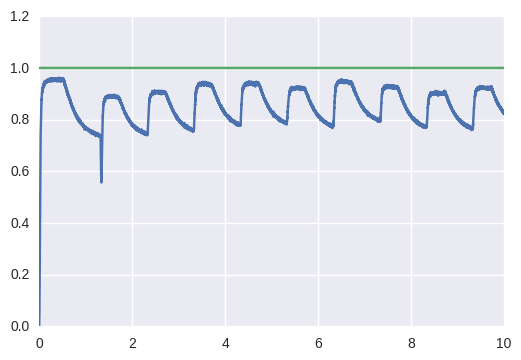

In [34]:
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_out], axis=1))
plt.plot(sim.trange(), np.linalg.norm(b, axis=1))

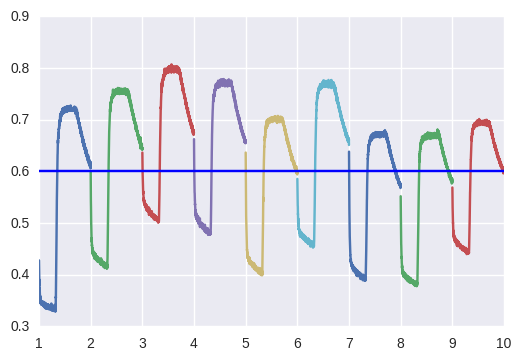

In [36]:
t = sim.trange()
y = np.sum(sim.data[p_in] * sim.data[p_out], axis=1)
for i in range(1, 10):
    sel = (t > i) & (t <= i + 1)
    plt.plot(t[sel], y[sel])
plt.axhline(y=beta)

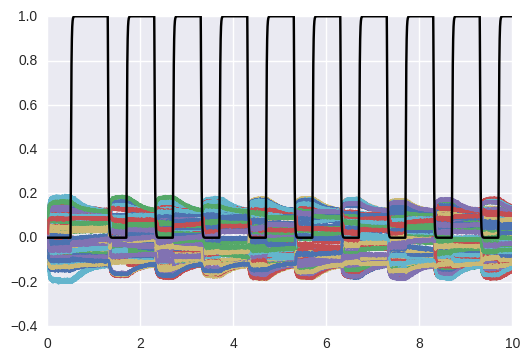

In [27]:
plt.plot(sim.trange(), sim.data[p_out]);
plt.plot(sim.trange(), sim.data[p_out_store], c='k')

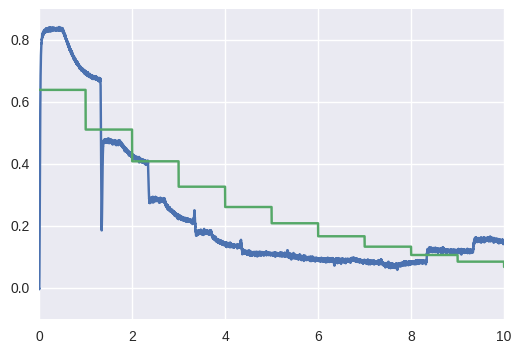

In [29]:
plt.plot(sim.trange(), np.dot(sim.data[p_out], vocab['InitCtx'].v))
plt.plot(sim.trange(), np.sqrt(1. - beta**2) ** np.floor(sim.trange() + 2.))

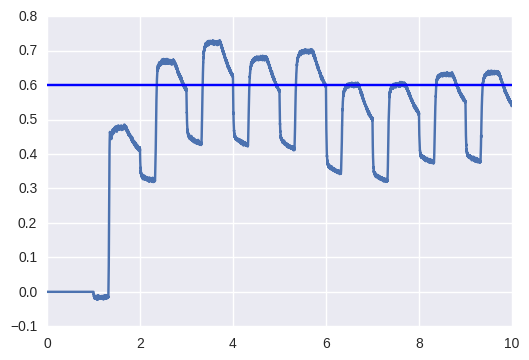

In [30]:
plt.plot(sim.trange(), np.sum(sim.data[p_out] * sim.data[p_in], axis=1))
plt.axhline(y=beta)

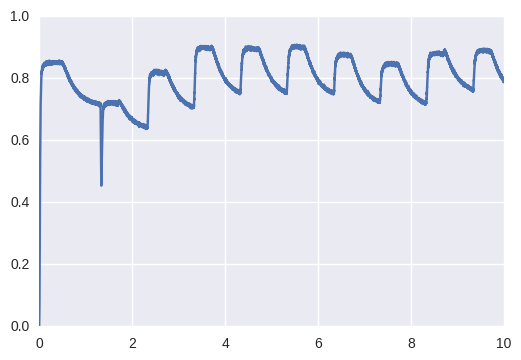

In [31]:
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_out], axis=1))

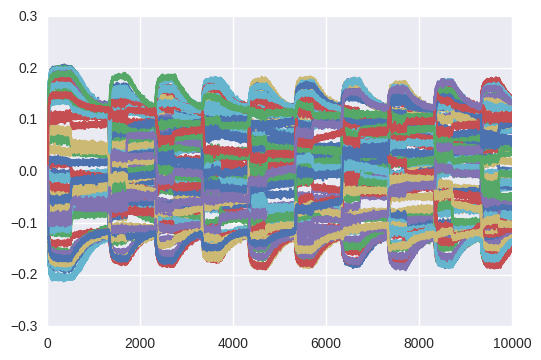

In [30]:
plt.plot(sim.data[p_out]);

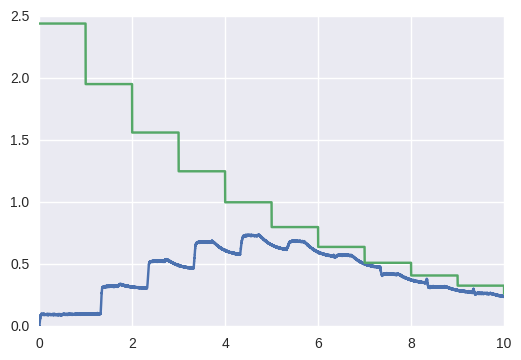

In [42]:
t = 4
plt.plot(sim.trange(), np.dot(sim.data[p_out], sim.data[p_out][1000*t + 900]))
plt.plot(sim.trange(), np.sqrt(1. - beta**2) ** np.floor(sim.trange() - t))

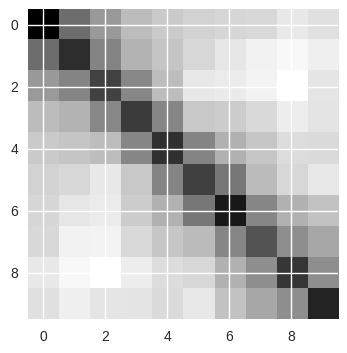

In [72]:
a = np.mean([sim.data[p_out][(1000 * i + 500):(1000 * i + 900)] for i in range(10)], axis=1)
plt.imshow(np.dot(a, a.T), interpolation='nearest')

In [126]:
def val(mat):
    a = np.zeros(2 * mat.shape[0] - 1)
    for i in range(mat.shape[0]):
        start = mat.shape[0] - i - 1
        end = mat.shape[0] - i - 1 + mat.shape[1]
        a[start:end] += mat[i, :]
    a /= mat.shape[0] - np.abs(mat.shape[0] - 1 - np.arange(2 * mat.shape[0] - 1))
    return a

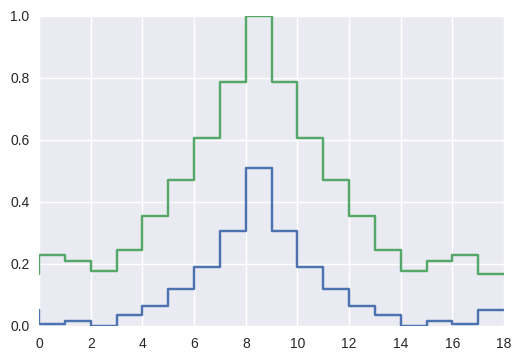

In [127]:
plt.step(range(19), val(np.dot(a, a.T)))
plt.step(range(19), val(np.dot(b, b.T)))

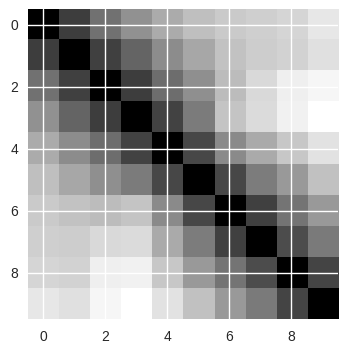

In [121]:
def stim(t):
    return vocab.parse('IN' + str(t)).v
    v = vocab.parse('InitStim').v
    for i in range(int(t)):
        v = np.sqrt(1. - beta**2) * v + beta * vocab.parse('IN' + str(i)).v
        v /= np.linalg.norm(v)
    return v

def ctx(t):
    v = vocab.parse('InitCtx').v
    for i in range(int(t)):
        x = stim(i)
        #rho = np.sqrt(1. + beta**2 * (np.dot(v, x)**2 - 1)) - beta * np.dot(v, x)
        #v = rho * v + beta * x
        v = np.sqrt(1. - beta**2) * v + beta * stim(i)
        v /= np.linalg.norm(v)
    return v

b = np.array([ctx(i) for i in range(10)])
b /= np.linalg.norm(b, axis=1)[:, None]
plt.imshow(np.dot(b, b.T), interpolation='nearest')

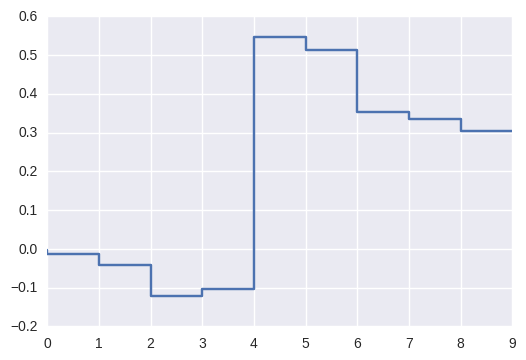

In [123]:
c = np.array([ctx(i) for i in range(10)])
c /= np.linalg.norm(c, axis=1)[:, None]
plt.step(range(10), np.dot(c, stim(4)))
#plt.ylim(0, 1)

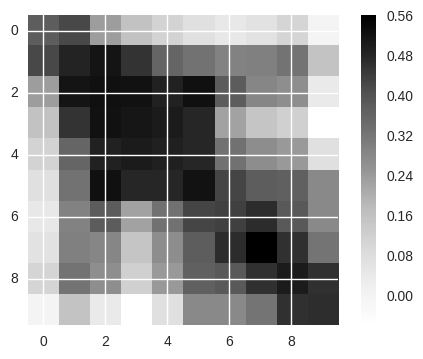

In [76]:
plt.imshow(np.dot(b, b.T) - np.dot(a, a.T), interpolation='nearest')
plt.colorbar()

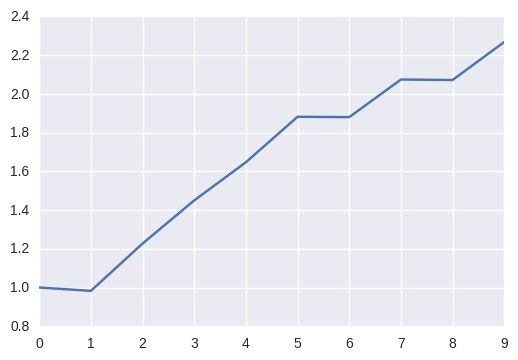

In [52]:
plt.plot(np.linalg.norm(b, axis=1))